<p style="float:right">
<img src="images/cu.png" style="display:inline" />
<img src="images/cires.png" style="display:inline" />
<img src="images/nasa.png" style="display:inline" />
</p>

# Python, Jupyter & pandas tutorial: Module 2

## Obtaining data and basic inspection

### Basic data access

It is, of course, possible to obtain data (rougly construed -- we'll look at images here because they're simple to view) externally (or via the `%%script` magic, which saves the trouble of opening a separate terminal / command / browser window). We can fetch an image to the local filesystem, then display it with Markdown:

In [1]:
%%script bash
wget ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/Feb/N_197902_extn.png

--2016-03-14 15:53:48--  ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/Feb/N_197902_extn.png
           => 'N_197902_extn.png'
Resolving sidads.colorado.edu... 128.138.135.20
Connecting to sidads.colorado.edu|128.138.135.20|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /DATASETS/NOAA/G02135/Feb ... done.
==> SIZE N_197902_extn.png ... 224912
==> PASV ... done.    ==> RETR N_197902_extn.png ... done.
Length: 224912 (220K) (unauthoritative)

     0K .......... .......... .......... .......... .......... 22% 10.9M 0s
    50K .......... .......... .......... .......... .......... 45% 14.0M 0s
   100K .......... .......... .......... .......... .......... 68% 7.92M 0s
   150K .......... .......... .......... .......... .......... 91% 16.9M 0s
   200K .......... .........                                  100% 22.5M=0.02s

2016-03-14 15:53:48 (12.0 MB/s) - 'N_197902_extn.png' saved [224912]



<img src='N_197902_extn.png' style='float:left'/>

We can also obtain an image directly from the internet and display in with Python code:

In [2]:
from IPython.display import Image
Image(url='ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/Feb/N_201602_extn.png')

# Yo! Do the "Total area" figures account for the difference in pole-hole size? Seems like, here, the hole is full of ice, but what about earlier/later in the season?

### OpenDAP data access

The `netCDF4` package provide OpenDAP client capabilities. Here we use it to obtain data via an OpenDAP server at NSIDC:

In [3]:
import netCDF4
opendap_base = 'http://opendap.apps.nsidc.org:80/opendap/DATASETS'
opendap_data = 'nsidc0530_MEASURES_nhsnow_daily25/2012/nhtsd25e2_20120101_v01r01.nc'
url = '/'.join([opendap_base, opendap_data])
dataset = netCDF4.Dataset(url)

We can introspect the `dataset` object to see its class. In this case, it's exactly what we'd expect given that we created it with `netCDF4.Dataset`. However, it's sometimes the case, especially when working with a new library, that we do not anticipate the type of an object returned from some method / function call, so it's handy to be able to find out what it is.

In [4]:
type(dataset)

netCDF4._netCDF4.Dataset

Given that we have a `Dataset` object from the `netCDF4` library, we could of course go consult that library's documentation to learn what kinds of attributes and methods such an object has. Or, we can bravely plunge in and have a look for ourselves. Here, we use Python's built-in `dir` command to get a list of object members. We filter out those whose names begin with `_`, as these are generally not meant to be used directly.

In [5]:
import re
list(filter(lambda x: not re.match('^_.*', x), dir(dataset)))

['Conventions',
 'DODS_EXTRA.Unlimited_Dimension',
 'Metadata_Conventions',
 'cdm_data_type',
 'close',
 'cmptypes',
 'createCompoundType',
 'createDimension',
 'createEnumType',
 'createGroup',
 'createVLType',
 'createVariable',
 'data_model',
 'date_created',
 'delncattr',
 'dimensions',
 'disk_format',
 'enumtypes',
 'file_format',
 'filepath',
 'geospatial_lat_max',
 'geospatial_lat_min',
 'geospatial_lat_units',
 'geospatial_lon_max',
 'geospatial_lon_min',
 'geospatial_lon_units',
 'get_variables_by_attributes',
 'getncattr',
 'groups',
 'id',
 'institution',
 'isopen',
 'keepweakref',
 'keywords',
 'keywords_vocabulary',
 'license',
 'metadata_link',
 'naming_authority',
 'ncattrs',
 'parent',
 'path',
 'platform',
 'product_version',
 'reference',
 'renameAttribute',
 'renameDimension',
 'renameGroup',
 'renameVariable',
 'sensor',
 'set_auto_mask',
 'set_auto_maskandscale',
 'set_auto_scale',
 'set_fill_off',
 'set_fill_on',
 'setncattr',
 'setncatts',
 'source',
 'spatial_re

Looking at this list, some items appear to be metadata, e.g. those starting with `geospatial_`, or `institution` or `platform`. We can look at the name of the dataset via the `title` attribute:

In [6]:
dataset.title

'MEaSUREs Northern Hemisphere Terrestrial Snow Cover Extent Daily 25km EASE-Grid 2.0'

We can refer to [this dataset's documentation](http://nsidc.org/data/docs/measures/nsidc-0530/index.html) for more information about the meaning of these attributes.

The actual data is available under `variables`: 

In [7]:
for variable in dataset.variables:
    print(variable)

time
rows
cols
coord_system
latitude
longitude
merged_snow_cover_extent
ims_snow_cover_extent
passive_microwave_gap_filled_snow_cover_extent
modis_cloud_gap_filled_snow_cover_extent


Note that these variables correspond to those listed in Table 3 of the documentation page linked to above.

Let's extract the `latitude` variable and look at its properties. In a Jupyter notebook, as in a Python REPL -- but unlike in non-interactive Python code -- simply giving the name of an object will cause its textual representation to be printed. (In a Jupyter notebook, this only works on the last line of a cell.)

In [8]:
latitude = dataset.variables['latitude']
latitude

<class 'netCDF4._netCDF4.Variable'>
float32 latitude(rows, cols)
    _FillValue: -999.0
    long_name: latitude of cell center in EASE-Grid-2.0
    units: degrees_north
    valid_range: [-90.  90.]
    standard_name: latitude
unlimited dimensions: 
current shape = (720, 720)
filling off

Lots of useful information! `latitude` is a 720x720 array, with valid values ranging from -90 to 90 degrees north, and invalid ("fill") marked as -999.

Since we pulled `latitude` out of another object, rather than creating it explicitly as we did with the `Dataset`, what kind of object do we have?

In [9]:
type(latitude)

netCDF4._netCDF4.Variable

No surprise there. And how are the data in this variable represented?

In [10]:
latitude.datatype

dtype('float32')

As 32-bit floating-point numbers. We also saw, but might not have noticed, this when we printed `latitude`, above: Note the `float32` designation in the second line. Similarly, all the other data shown above can be extracted with more targeted queries:

In [11]:
latitude.long_name

'latitude of cell center in EASE-Grid-2.0'

In [12]:
latitude.valid_range

array([-90.,  90.], dtype=float32)

In [13]:
latitude.shape

(720, 720)

We can also extract metadata that we could otherwise compute:

In [14]:
latitude.ndim

2

In [15]:
latitude.size

518400

These are shorthand for

In [16]:
len(latitude.shape)

2

In [17]:
latitude.shape[0] * latitude.shape[1]

518400

Just as with our `Dataset`, we can look at all the public attributes and methods of our `Variable`:

In [18]:
list(filter(lambda x: not re.match('^_.*', x), dir(latitude)))

['assignValue',
 'chunking',
 'datatype',
 'delncattr',
 'dimensions',
 'dtype',
 'endian',
 'filters',
 'getValue',
 'get_var_chunk_cache',
 'getncattr',
 'group',
 'long_name',
 'mask',
 'name',
 'ncattrs',
 'ndim',
 'renameAttribute',
 'scale',
 'set_auto_mask',
 'set_auto_maskandscale',
 'set_auto_scale',
 'set_var_chunk_cache',
 'setncattr',
 'setncatts',
 'shape',
 'size',
 'standard_name',
 'units',
 'valid_range']

Instances of the `Variable` class (like our `latitude` object) from `netCDF``latitude` variable behave like multidimensional arrays, similar to NumPy's `ndarray`. So, we can access elements with the familiar `[]` bracket notation. Since we know that `latitude` is 720x720, as we expect:

In [19]:
len(latitude)

720

And if we look at the first row in the `latitude` array, its length is similarly what we'd expect:

In [20]:
len(latitude[0])

720

Note that Python is zero-indexed like C, and unlike Fortran, so valid indices range from 0 to 719:

In [32]:
print(latitude[0][720])

IndexError: index 720 is out of bounds for axis 0 with size 720

Let's extract the `time` variable from our dataset and examine it. (Note that we can view output from commands other than the last one in a cell by explicitly using Python's `print` command.)

In [21]:
time = dataset.variables['time']
print(time)
print(time[0])

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    calendar: gregorian
    axis: T
    units: days since 1998-12-31
    long_name: time
    standard_name: time
unlimited dimensions: time
current shape = (1,)
filling off

4749


So, this dataset's data starts 4749 days after 1998-12-31 on the Gregorian calendar. Handy! (Not really.)

Out of curiosity, let's check that the `longitude` variable's shape conforms to that of `latitude`, as we'd hope.

In [33]:
longitude = dataset.variables['longitude']
longitude

<class 'netCDF4._netCDF4.Variable'>
float32 longitude(rows, cols)
    _FillValue: -999.0
    long_name: longitude of cell center in EASE-Grid-2.0
    units: degrees_east
    valid_range: [-180.  180.]
    standard_name: longitude
unlimited dimensions: 
current shape = (720, 720)
filling off

Good, it does.

Now let's look at one of the actual snow-cover variables which, presumably, is why we're bothering with this dataset in the first place:

In [23]:
msce = dataset.variables['merged_snow_cover_extent']
msce

<class 'netCDF4._netCDF4.Variable'>
int16 merged_snow_cover_extent(time, rows, cols)
    flag_meanings: modis_microwave_ims_report_snow modis_microwave_report_snow modis_ims_report_snow microwave_ims_report_snow modis_only_reports_snow microwave_only_reports_snow ims_only_reports_snow snow_free_land permanent_ice ocean
    flag_values: [10 11 12 13 14 15 16 20 30 40]
    _FillValue: -99
    comment: 10: Snow cover reported by modis_cloud_gap_filled, passive_microwave, ims, 11: Snow cover reported by modis_cloud_gap_filled, passive_microwave,  12: Snow cover reported by modis_cloud_gap_filled, ims, 13: Snow cover reported by passive_microwave, ims, 14: Snow cover reported by modis_cloud_gap_filled only, 15: Snow cover reported by passive_microwave only, 16: Snow cover reported by ims only, 20: Snow free land, 30: Permanent ice covered land, 40: Ocean
    valid_range: [10 40]
    coordinates: longitude latitude time
    long_name: Merged Snow Cover Extent
    grid_mapping: coord_system
u

In [24]:
msce[0][360][360]

40

In [25]:
import numpy as np
msce = np.array(msce)[0, :, :]
msce.shape

(720, 720)

In [26]:
print(msce.size)
print(msce[msce != -99].size)

518400
408052


In [27]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

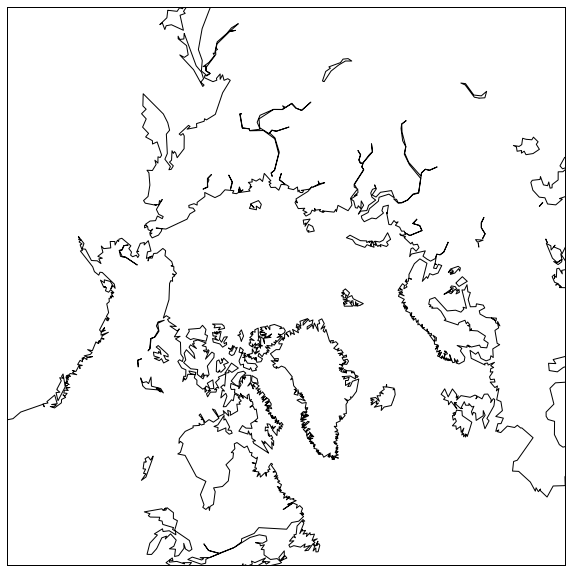

In [28]:
%matplotlib inline
plt.figure(figsize=(10, 10))
m = Basemap(projection='npstere', boundinglat=45, lon_0=300)
m.drawcoastlines()
plt.show()

In [29]:
# https://peak5390.wordpress.com/2012/12/08/matplotlib-basemap-tutorial-plotting-points-on-a-simple-map/